# Boosting Black Box Variational Inference
## Introduction
This tutorial demonstrates how to implement boosting black box Variational Inference [1] in Pyro. In boosting Variational Infernce, we approximate a target distribution with a iteratively selected mixture of densities. In cases where a single denisity provided by regular Variational Inference doesn't adequately approximate a target density, boosting VI thus offers a simple way of getting more complex approximations. 

## Contents
* [Theoretical Background](#theoretical-background)
    - Variational Inference
    - Boosting Black Box Variational Inference
* [BBBVI in Pyro](#bbbvi-pyro)

## Theoretical Background <a class="anchor" id="theoretical-background"></a>

### Variational Inference
For an introduction to regular Variational Inference, we recommend first having a look at [the tutorial on SVI in Pyro](https://pyro.ai/examples/svi_part_i.html).

Briefly, Variational Inference allows us to find approximations of probability densities which are intractable to compute analytically. First, one chooses a set of tractable densities, a variational family, and then tries to find the element of this set which most closely approximates the target distribution.
This approximating density is found by maximizing the Evidence Lower BOund (ELBO):
$$ \mathbb{E}_s[\text{log} p(x, z)] - \mathbb{E}_s[\text{log} s(z)]$$

where $s(z)$ is the approximating density and $p(x,z)$ is the target distribution.

### Boosting Black Box Variational Inference

In boosting BBVI, the approximation takes the form:
$$\sum_{i=1}^T \gamma_t s_t(z)$$

$$\text{where} \sum_{i=1}^T \gamma_t =1$$

and $s_t(z)$ are elements of the variational family.

The components of the approximation $s_t(z)$ are selected greedily components by maximising the Residual ELBO (RELBO):

$$\mathbb{E}_s[\text{log} p(x,z)] - \lambda \mathbb{E}_s[\text{log}s(z)] - \mathbb{E}_s[\text{log} q^t(z)]$$

It's called *black box* variational inference inference because this optimisation does not have to be tailored to the variational family which is being used. Setting $\lambda$ to 1, regular SVI methods can be used to compute $$\mathbb{E}_s[\text{log} p(x,z)] - \lambda \mathbb{E}_s[\text{log}s(z)]$$. See the explanation of the section on the implementation of the RELBO below for an explanation of how we compute the term  $- \mathbb{E}_s[\text{log} q^t(z)]$. Imporantly, we do not need to make any additional assumptions about the variational family that's being used to ensure that this algorithm converges. 

In [1] a number of different ways of finding the mixture weights $\gamma_t$ are suggested, ranging from fixed step sizes based on the iteration to solving the optimisation problem of finding $\gamma_t$ that will minimise the RELBo.

 


## BBBVI in Pyro <a class="anchor" id="bbbvi-pyro"></a>

To implement boosting black box variational inference in Pyro, we need to consider the following three components:
1. The approximation components (guides) and the approximation itself.
2. The RELBO.
3. Running SVI to find new components and update the approximation.

We will illustrate these points by looking at simple example: approximating a bimodal posterior.


### The Model

Boosting BBVI is particularly useful in situations where we're trying to approximate mulitmodal posteriors. In this tutorial, we'll thus consider the following model:
 
 $$\mu \sim \mathcal{N}(0,5)$$
 $$y \sim \mathcal{N}(\mu^2, 0.1)$$
 
Additionally, we have some observations of $y$ around +4. We thus expect $p(\mu|y)$ to be a bimodal distributions with modes around -2 and +2.
 
In Pyro, this model takes the following shape:

In [17]:
def model(data):
    # Global variables.
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    loc = pyro.sample('loc', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        # Local variables.
        pyro.sample('obs', dist.Normal(loc*loc, scale), obs=data)

### The Guide

Next, we specify the guide which in our case will make up the compoents of our mixture. Recall that in Pyro the guide needs to take the same arguments as the model which is why our guide function also takes the data as an input. 

We also need to make sure that every `pyro.sample()` statement from the model has a matching `pyro.sample()` statement in the guide. In our case, we include `loc` in both the model and the guide.

In contrast to regular SVI, our guide takes an additional argument: `index`. Having this argument allows us to easily create new guides in each iteration of the greedy algorithm. In particular, we use make use of `partial()` from the [functools library](https://docs.python.org/3.7/library/functools.html) to create guides which only take `data` as an argument. The statement `partial(guide, index=t)` creates a guide that will take only `data` as an input and which has trainable parameters `scale_t` and `loc_t`.

Putting all of this together, we get the following guide:

In [6]:
def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([1.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

### The RELBO

We implement a modified ELBO function which we then pass to Pyro's SVI class to do the heavy lifting for us.

Conveniently, the RELBO is very similar to the normal ELBO which allows us to reuse the Pyro's existing ELBO to compute part of it. Specifically, we compute 
$$E_s[\text{log} p(x,z)] - \lambda E_s[\text{log}s]$$
using `Trace_ELBO` and then compute 
$$ - E_s[\text{log} q^t]$$
using Poutine. For some background on how this works, we recommend going through the tutorials [on Poutine](https://pyro.ai/examples/effect_handlers.html) and [custom SVI objectives](https://pyro.ai/examples/custom_objectives.html).

In [18]:
def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    relbo_lambda = kwargs.pop('relbo_lambda', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    replayed_approximation = trace(replay(block(approximation, expose=['loc']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)
    # We will acculoclate the various terms of the ELBO in `elbo`.


    loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                                             guide,
                                                                             *args,
                                                                             **kwargs)

    elbo = -loss_fn - approximation_trace.log_prob_sum()

    return -elbo

### The Approximation

Our approximation $\sum_{i=1}^T \gamma_t s_t(z)$ consists of a list of components, i.e. the guides from the greedy selection steps, and a list containing the mixture weights of the components. To sample from the approximation, we thus first sample an index of a component according to the mixture weights. In a second step, we get a sample from the corresponding component.

Similarly as with the guide, we use `partial(approximation, components=components, weights=weights)` to get an approximation function which has the same signature as the model.

In [169]:
def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result        

### The Greedy Algorithm

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . loc = -2.01552677154541
scale = 0.03500283882021904
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . loc = 2.0315308570861816
scale = 0.04819779098033905


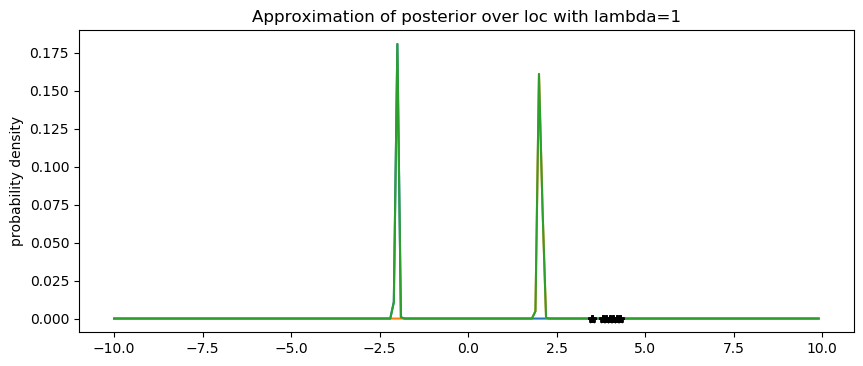

In [15]:
import os
from collections import defaultdict
from functools import partial

import numpy as np
import pyro
import pyro.distributions as dist
import scipy.stats
import torch 
import torch.distributions.constraints as constraints
from matplotlib import pyplot
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.poutine import block, replay, trace

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 10000
pyro.set_rng_seed(2)

# enable validation (e.g. validate parameters of distributions)
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

data = torch.tensor([4.0, 4.2, 3.9, 4.1, 3.8, 3.5, 4.3]*10)

def guide(data, index):
    scale_q = pyro.param('scale_{}'.format(index), torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_{}'.format(index), torch.tensor([0.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

def model(data):
    # Global variables.
    prior_loc = torch.tensor([0.])
    prior_scale = torch.tensor([5.])
    loc = pyro.sample('loc', dist.Normal(prior_loc, prior_scale))
    scale = torch.tensor([0.1])

    with pyro.plate('data', len(data)):
        # Local variables.
        pyro.sample('obs', dist.Normal(loc*loc, scale), obs=data)

def relbo(model, guide, *args, **kwargs):

    approximation = kwargs.pop('approximation', None)
    relbo_lambda = kwargs.pop('relbo_lambda', None)
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to Pyro primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    replayed_approximation = trace(replay(block(approximation, expose=['loc']), guide_trace))
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)
    # We will acculoclate the various terms of the ELBO in `elbo`.


    loss_fn = pyro.infer.Trace_ELBO(max_plate_nesting=1).differentiable_loss(model,
                                                                             guide,
                                                                             *args,
                                                                             **kwargs)

    elbo = -loss_fn -  approximation_trace.log_prob_sum()

    return -elbo

def approximation(data, components, weights):
    assignment = pyro.sample('assignment', dist.Categorical(weights))
    result = components[assignment](data)
    return result

def dummy_approximation(data):
    scale_q = pyro.param('scale_0', torch.tensor([1.0]), constraints.positive)
    loc_q = pyro.param('loc_0', torch.tensor([20.0]))
    pyro.sample("loc", dist.Normal(loc_q, scale_q))

def boosting_bbvi():
    n_iterations = 2
    relbo_lambda = 1
    initial_approximation = partial(guide, index=0)
    components = [initial_approximation]
    weights = torch.tensor([1.])
    wrapped_approximation = partial(approximation, components=components, weights=weights)

    locs = [0]
    scales = [0]

    duality_gap = []
    entropies = []
    model_log_likelihoods = []
    for t in range(1, n_iterations + 1):
        # setup the inference algorithm
        wrapped_guide = partial(guide, index=t)
        # do gradient steps
        losses = []
        # Register hooks to monitor gradient norms.

        adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
        optimizer = Adam(adam_params)

        svi = SVI(model, wrapped_guide, optimizer, loss=relbo)
        for step in range(n_steps):
            loss = svi.step(data, approximation=wrapped_approximation, relbo_lambda=relbo_lambda)
            losses.append(loss)

            if step % 100 == 0:
                print('.', end=' ')

        components.append(wrapped_guide)
        new_weight = 2 / (t + 1)

        if t == 2:
            new_weight = 0.5
        weights = weights * (1-new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))

        wrapped_approximation = partial(approximation, components=components, weights=weights)

        scale = pyro.param("scale_{}".format(t)).item()
        scales.append(scale)
        loc = pyro.param("loc_{}".format(t)).item()
        locs.append(loc)
        print('loc = {}'.format(loc))
        print('scale = {}'.format(scale))


    X = np.arange(-10, 10, 0.1)
    pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    total_approximation = np.zeros(X.shape)
    for i in range(1, n_iterations + 1):
        Y = weights[i].item() * scipy.stats.norm.pdf((X - locs[i]) / scales[i])
        pyplot.plot(X, Y)
        total_approximation += Y
    pyplot.plot(X, total_approximation)
    pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
    pyplot.title('Approximation of posterior over loc with lambda={}'.format(relbo_lambda))
    pyplot.ylabel('probability density')
    pyplot.show()

if __name__ == '__main__':
    boosting_bbvi()


### References

[1] Locatello, Francesco, et al. "Boosting black box variational inference." Advances in Neural Information Processing Systems. 2018.

[2] Ranganath, Rajesh, Sean Gerrish, and David Blei. "Black box variational inference." Artificial Intelligence and Statistics. 2014.